In [1]:
%%bash
pip3 install pillow --user
pip3 install efficientnet --user

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, NASNetLarge, NASNetMobile, ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2, VGG16, VGG19, Xception
# from tensorflow.python.lib.io import file_io

import os
import numpy as np
import matplotlib.pyplot as plt

from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

2.1.0


In [3]:
home_dir = os.environ['HOME']
base_dir = os.path.join(home_dir, 'data-vol-1')

In [4]:
######################################################################################################################
# Download the CSV generated by AutoML where images are sorted into TRAIN, VALIDATION and TEST randomly at 80%:10%:10%
# Comment out to save time. Both file_io and gfile fail with local cache.
######################################################################################################################
csv_file = os.path.join(home_dir, 'data-vol-1/kubeflow/notebooks/idr0042.csv')

os.system("mkdir -p " + os.path.join(base_dir, 'kubeflow/notebooks'))
# file_io.copy(oldpath='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv',
#              newpath=csv_file, overwrite=True)
tf.io.gfile.copy(src='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv', dst=csv_file, overwrite=True)

with open(csv_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        dataset_name = tokens[0].lower()
        source = tokens[1]
        label_name = tokens[2].strip('\n')
        fname = source.split('/')[-1]

        os.system("mkdir -p " + os.path.join(base_dir, dataset_name, label_name))
#         file_io.copy(oldpath=source, newpath=os.path.join(base_dir, dataset_name, label_name, fname), overwrite=True)
        tf.io.gfile.copy(src=source, dst=os.path.join(base_dir, dataset_name, label_name, fname), overwrite=True)
        print(line)

In [5]:
#####################
# Understand the data
#####################
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')
test_failure_dir = os.path.join(test_dir, 'chronic_heart_failure')
test_healthy_dir = os.path.join(test_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
num_failure_tst = len(os.listdir(test_failure_dir))
num_healthy_tst = len(os.listdir(test_healthy_dir))

total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total_tst = num_failure_tst + num_healthy_tst
total = total_train + total_val + total_tst

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print('Total test failure images:', num_failure_tst)
print('Total test healthy images:', num_healthy_tst)

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_tst)
print("Total images:", total)

Total training failure images: 827
Total training healthy images: 755
Total validation failure images: 104
Total validation healthy images: 95
Total test failure images: 103
Total test healthy images: 94
Total training images: 1582
Total validation images: 199
Total test images: 197
Total images: 1978


In [6]:
############################################
# Train the model with weights of 'imagenet'
############################################
def transfer(base_model, _trainable: bool = True):
    _model = tf.keras.Sequential([
        base_model,

        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    base_model.trainable = _trainable

#     base_learning_rate = 0.0001
    _model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, amsgrad=False),
#         optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])

    _model.summary()
    base_model.summary()
    return _model

In [7]:
#################################
# Training and validation history
#################################
def plothistory(_history, name: str = None):
    acc = _history.history['accuracy']
    val_acc = _history.history['val_accuracy']

    loss = _history.history['loss']
    val_loss = _history.history['val_loss']

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('{} - Training and Validation Accuracy'.format(name))

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('{} - Training and Validation Loss'.format(name))
    plt.xlabel('epoch')
    plt.show()

In [8]:
########################################
# generate data for train and validation
########################################
batch_size = 64
epochs = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1582 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [9]:
###################################################################
# Training Keras Application EfficientNetB0 with weights='imagenet'
###################################################################
model = transfer(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               5898752   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 9,948,829
Trainable params: 9,906,813
Non-trainable params: 42,016
_________________________________________________________________
Model: "efficientnet-b0"
__________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/30
24/24 [==============================] - 20s 817ms/step - loss: 0.8703 - accuracy: 0.5487 - val_loss: 0.7482 - val_accuracy: 0.5156
Epoch 2/30
24/24 [==============================] - 7s 296ms/step - loss: 0.6174 - accuracy: 0.6746 - val_loss: 0.7221 - val_accuracy: 0.5521
Epoch 3/30
24/24 [==============================] - 7s 295ms/step - loss: 0.5088 - accuracy: 0.7306 - val_loss: 0.7141 - val_accuracy: 0.5312
Epoch 4/30
24/24 [==============================] - 7s 296ms/step - loss: 0.4456 - accuracy: 0.7760 - val_loss: 0.7117 - val_accuracy: 0.5469
Epoch 5/30
24/24 [==============================] - 7s 296ms/step - loss: 0.3753 - accuracy: 0.8333 - val_loss: 0.7268 - val_accuracy: 0.5521
Epoch 6/30
24/24 [==============================] - 7s 298ms/step - loss: 0.3357 - accuracy: 0.8498 - val_loss: 0.7291 - val_accuracy: 0.5573
Epoch 7/30
24/24 [==============================] - 7s 2

In [10]:
plothistory(history, 'EfficientNetB0')

In [11]:
###################################################################
# Training Keras Application EfficientNetB1 with weights='imagenet'
###################################################################
model = transfer(EfficientNetB1(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 7, 7, 1280)        6575232   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5898752   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 12,474,497
Trainable params: 12,412,449
Non-trainable params: 62,048
_________________________________________________________________
Model: "efficientnet-b1"
______________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/30
24/24 [==============================] - 23s 955ms/step - loss: 0.7386 - accuracy: 0.5896 - val_loss: 0.7158 - val_accuracy: 0.5521
Epoch 2/30
24/24 [==============================] - 10s 420ms/step - loss: 0.5989 - accuracy: 0.6785 - val_loss: 0.6987 - val_accuracy: 0.6198
Epoch 3/30
24/24 [==============================] - 10s 417ms/step - loss: 0.5110 - accuracy: 0.7477 - val_loss: 0.6828 - val_accuracy: 0.5938
Epoch 4/30
24/24 [==============================] - 10s 418ms/step - loss: 0.4530 - accuracy: 0.7846 - val_loss: 0.6838 - val_accuracy: 0.5885
Epoch 5/30
24/24 [==============================] - 10s 417ms/step - loss: 0.3797 - accuracy: 0.8235 - val_loss: 0.6761 - val_accuracy: 0.5990
Epoch 6/30
24/24 [==============================] - 10s 419ms/step - loss: 0.3661 - accuracy: 0.8300 - val_loss: 0.6708 - val_accuracy: 0.5781
Epoch 7/30
24/24 [==============================] -

In [12]:
plothistory(history, 'EfficientNetB1')

In [13]:
###################################################################
# Training Keras Application EfficientNetB2 with weights='imagenet'
###################################################################
model = transfer(EfficientNetB2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 7, 7, 1408)        7768562   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 1408)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12672)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6488576   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 14,257,651
Trainable params: 14,190,083
Non-trainable params: 67,568
_________________________________________________________________
Model: "efficientnet-b2"
______________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/30
24/24 [==============================] - 24s 983ms/step - loss: 0.7643 - accuracy: 0.5729 - val_loss: 0.7046 - val_accuracy: 0.5469
Epoch 2/30
24/24 [==============================] - 11s 451ms/step - loss: 0.5845 - accuracy: 0.6884 - val_loss: 0.6765 - val_accuracy: 0.5677
Epoch 3/30
24/24 [==============================] - 10s 424ms/step - loss: 0.5084 - accuracy: 0.7345 - val_loss: 0.6899 - val_accuracy: 0.5625
Epoch 4/30
24/24 [==============================] - 10s 420ms/step - loss: 0.4365 - accuracy: 0.7793 - val_loss: 0.6993 - val_accuracy: 0.5677
Epoch 5/30
24/24 [==============================] - 10s 425ms/step - loss: 0.3888 - accuracy: 0.8267 - val_loss: 0.6681 - val_accuracy: 0.5990
Epoch 6/30
24/24 [==============================] - 10s 427ms/step - loss: 0.3572 - accuracy: 0.8281 - val_loss: 0.6433 - val_accuracy: 0.6302
Epoch 7/30
24/24 [==============================] -

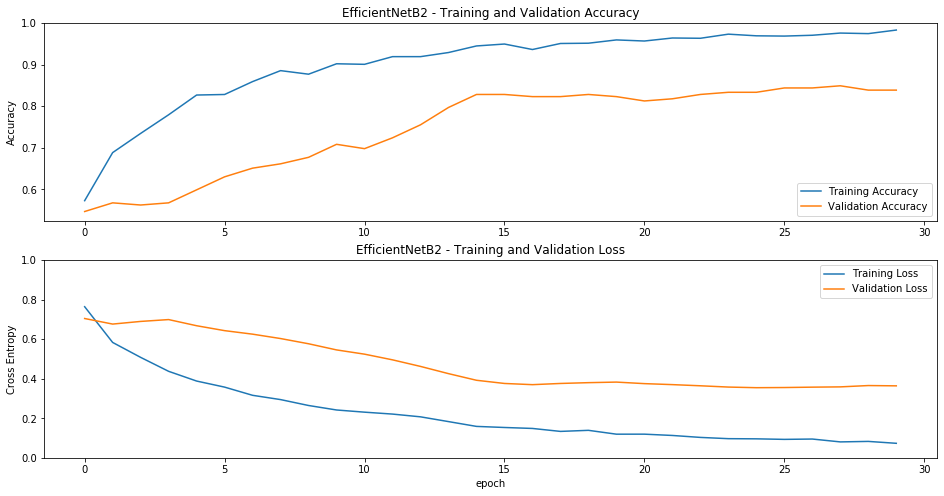

In [14]:
plothistory(history, 'EfficientNetB2')

In [15]:
###################################################################
# Training Keras Application EfficientNetB3 with weights='imagenet'
###################################################################
model = transfer(EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               7078400   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 17,862,441
Trainable params: 17,775,145
Non-trainable params: 87,296
_________________________________________________________________
Model: "efficientnet-b3"
______________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/30
24/24 [==============================] - 29s 1s/step - loss: 0.7463 - accuracy: 0.5619 - val_loss: 0.6908 - val_accuracy: 0.5625
Epoch 2/30
24/24 [==============================] - 12s 498ms/step - loss: 0.6011 - accuracy: 0.6660 - val_loss: 0.6902 - val_accuracy: 0.5573
Epoch 3/30
24/24 [==============================] - 12s 505ms/step - loss: 0.4915 - accuracy: 0.7530 - val_loss: 0.7019 - val_accuracy: 0.5469
Epoch 4/30
24/24 [==============================] - 12s 496ms/step - loss: 0.4388 - accuracy: 0.7787 - val_loss: 0.6873 - val_accuracy: 0.5573
Epoch 5/30
24/24 [==============================] - 12s 494ms/step - loss: 0.3817 - accuracy: 0.8129 - val_loss: 0.6958 - val_accuracy: 0.5521
Epoch 6/30
24/24 [==============================] - 12s 496ms/step - loss: 0.3471 - accuracy: 0.8393 - val_loss: 0.6891 - val_accuracy: 0.5677
Epoch 7/30
24/24 [==============================] - 12

In [16]:
plothistory(history, 'EfficientNetB3')

In [17]:
###################################################################
# Training Keras Application EfficientNetB4 with weights='imagenet' - OOM 8 * VT100
###################################################################
# model = transfer(EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [18]:
# plothistory(history, 'EfficientNetB4')

In [19]:
###################################################################
# Training Keras Application EfficientNetB5 with weights='imagenet' - OOM 8 * VT100
###################################################################
# model = transfer(EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [20]:
# plothistory(history, 'EfficientNetB5')

In [21]:
###################################################################
# Training Keras Application EfficientNetB6 with weights='imagenet' - OOM 8 * VT100
###################################################################
# model = transfer(EfficientNetB6(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [22]:
# plothistory(history, 'EfficientNetB6')

In [23]:
###################################################################
# Training Keras Application EfficientNetB7 with weights='imagenet' - OOM 8 * VT100
###################################################################
# model = transfer(EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [24]:
# plothistory(history, 'EfficientNetB7')